<a href="https://colab.research.google.com/github/sanvisuv111/Excel_Data_Analytics_Course/blob/main/diabetic_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files: /kaggle/input/aptos2019


In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# --- 1. ROBUST FILE FINDER ---
# This loop hunts for 'train.csv' in every subfolder
csv_path = None
img_dir = None

print(f"Searching for files in: {path}")

for root, dirs, files in os.walk(path):
    if 'train_1.csv' in files:
        csv_path = os.path.join(root, 'train_1.csv')
        # Correct the image directory path: it seems to be nested
        img_dir = os.path.join(root, 'train_images', 'train_images') # Adjusted path
        print(f"FOUND IT! \nCSV is at: {csv_path} \nImages are at: {img_dir}")
        break

# FAIL-SAFE: If we still can't find it, stop here
if csv_path is None:
    print("\nERROR: Could not find train.csv. Listing all files found:")
    for root, dirs, files in os.walk(path):
        print(f"In {root}: {files}")
    raise FileNotFoundError("Could not locate train.csv. Check the list above.")

# --- 2. LOAD THE CSV ---
df = pd.read_csv(csv_path)
df['id_code'] = df['id_code'].apply(lambda x: x + ".png") # Add .png to filenames
df['diagnosis'] = df['diagnosis'].astype(str) # Convert labels to text

print(f"Successfully loaded metadata for {len(df)} images.")

# --- 3. DEFINE THE 'SECRET SAUCE' (CLAHE) ---
def apply_clahe(img):
    img = img.astype('uint8')
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final.astype('float32')

# --- 4. SETUP DATA GENERATORS ---
# We use a sample (1000 images) to make it run fast in Colab
train_df = df.sample(min(1000, len(df)), random_state=42)
val_df = df.drop(train_df.index).sample(min(200, len(df) - 1000), random_state=42)

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col="id_code",
    y_col="diagnosis",
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical"
)

print("\nData is ready for training!")

Searching for files in: /kaggle/input/aptos2019
FOUND IT! 
CSV is at: /kaggle/input/aptos2019/train_1.csv 
Images are at: /kaggle/input/aptos2019/train_images/train_images
Successfully loaded metadata for 2930 images.
Found 1000 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.

Data is ready for training!


In [ ]:
import os

print(f"Contents of image directory: {img_dir}")
if os.path.exists(img_dir):
    for root, dirs, files in os.walk(img_dir):
        print(f"In {root}: {len(dirs)} subdirectories, {len(files)} files")
        # Print a few sample files to see their names and structure
        if files:
            print("Sample files:", files[:5])
        if root == img_dir: # Only inspect the top level for now
            break
else:
    print(f"Image directory {img_dir} does not exist.")

Contents of image directory: /kaggle/input/aptos2019/train_images
In /kaggle/input/aptos2019/train_images: 1 subdirectories, 0 files


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam

# 1. BUILD THE MODEL
# Load ResNet50 with pre-trained weights (it already knows how to see features)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers (so we don't destroy the pre-learned patterns)
for layer in base_model.layers:
    layer.trainable = False

# Add our custom layers for Diabetic Retinopathy
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# Output layer: 5 neurons for the 5 stages of disease (0-4)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 2. COMPILE
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. TRAIN
print("Starting training... (This will take about 10-15 mins)")
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # 5 rounds of training
    verbose=1
)

print("Training Complete! Model is ready for XAI.")

Starting training... (This will take about 10-15 mins)
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.5596 - loss: 1.2113 - val_accuracy: 0.6800 - val_loss: 0.8651
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.7588 - loss: 0.6629 - val_accuracy: 0.7450 - val_loss: 0.7268
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.7972 - loss: 0.5569 - val_accuracy: 0.7450 - val_loss: 0.6973
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.8311 - loss: 0.5013 - val_accuracy: 0.7450 - val_loss: 0.6992
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.8380 - loss: 0.4534 - val_accuracy: 0.7700 - val_loss: 0.6803
Training Complete! Model is ready for XAI.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cc6c8be2e3e60b7babf7c4a38ac1a766cd839ef9f1465b8b3208f3b574fc2d2b
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Found a diseased eye (Class 4) at index 2)
Running LIME... (This takes about 1-2 minutes)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.18s/it]               



SUCCESS! Image saved as 'research_paper_result.png'


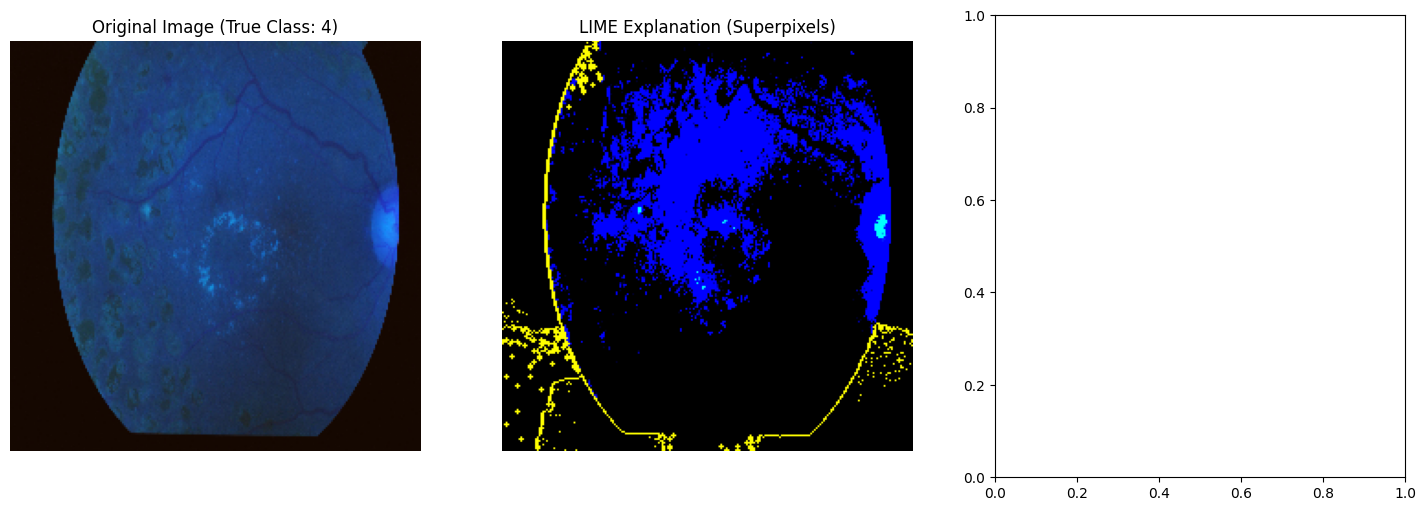

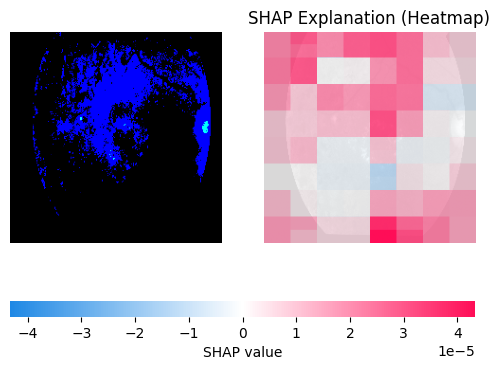

In [ ]:
!pip install lime
import shap
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# 1. GET A SAMPLE BATCH
# We grab a batch of images from the validation generator
x_batch, y_batch = next(valid_generator)

# 2. FIND A 'SICK' IMAGE TO EXPLAIN
# We don't want to explain a healthy eye (label 0). We want to find a diseased one.
# We loop through the batch to find the first image where the diagnosis is NOT 0.
image_index = 0
found_disease = False

for i in range(len(y_batch)):
    # y_batch is "one-hot encoded" (e.g., [0, 0, 0, 1, 0] means Class 3)
    # np.argmax converts it back to a number (0, 1, 2, 3, or 4)
    label = np.argmax(y_batch[i])
    if label > 1: # We look for Moderate (2) or Severe (3/4) for better visuals
        image_index = i
        found_disease = True
        print(f"Found a diseased eye (Class {label}) at index {i})")
        break

if not found_disease:
    print("Warning: This batch was mostly healthy. Using the first image anyway.")

# Select the image
sample_image = x_batch[image_index]

# 3. RUN LIME (Local Interpretable Model-agnostic Explanations)
print("Running LIME... (This takes about 1-2 minutes)")
explainer_lime = lime_image.LimeImageExplainer()

# We need a wrapper function because LIME expects a specific input format
def predict_fn(images):
    return model.predict(images)

explanation = explainer_lime.explain_instance(
    sample_image.astype('double'),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000  # Higher = clearer image, but slower
)

# Get the mask for the top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# 4. RUN SHAP (SHapley Additive exPlanations)
print("Running SHAP... (This might take 2-3 minutes)")
# We use a 'masker' to blur parts of the image to test importance
masker = shap.maskers.Image("inpaint_telea", sample_image.shape)
explainer_shap = shap.Explainer(model, masker)

# Calculate SHAP values for just this one image (to save time)
# We reshape it to (1, 224, 224, 3) because SHAP expects a batch
shap_values = explainer_shap(
    sample_image.reshape(1, 224, 224, 3),
    max_evals=500,
    batch_size=50,
    outputs=shap.Explanation.argsort.flip[:1]
)

# 5. PLOT AND SAVE
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
# We shift the values back to 0-1 range for display if they are normalized
disp_img = sample_image - np.min(sample_image)
disp_img = disp_img / np.max(disp_img)
plt.imshow(disp_img)
plt.title(f"Original Image (True Class: {np.argmax(y_batch[image_index])})")
plt.axis('off')

# LIME
plt.subplot(1, 3, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation (Superpixels)")
plt.axis('off')

# SHAP
plt.subplot(1, 3, 3)
# SHAP has its own plotter, but we can plot the heatmap manually for better control
# or use their built-in one. We'll use the built-in one for accuracy.
shap.image_plot(shap_values, show=False)
plt.title("SHAP Explanation (Heatmap)")

# Save for your paper
plt.savefig("research_paper_result.png", dpi=300, bbox_inches='tight')
print("\nSUCCESS! Image saved as 'research_paper_result.png'")
plt.show()

In [ ]:
from google.colab import files
files.download('research_paper_result.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Searching for a generic Severe DR case to explain...
Found a Severe DR case! Analyzing now...
Generating LIME (Superpixel) Explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:33, 33.74s/it]               
/tmp/ipython-input-4109855538.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


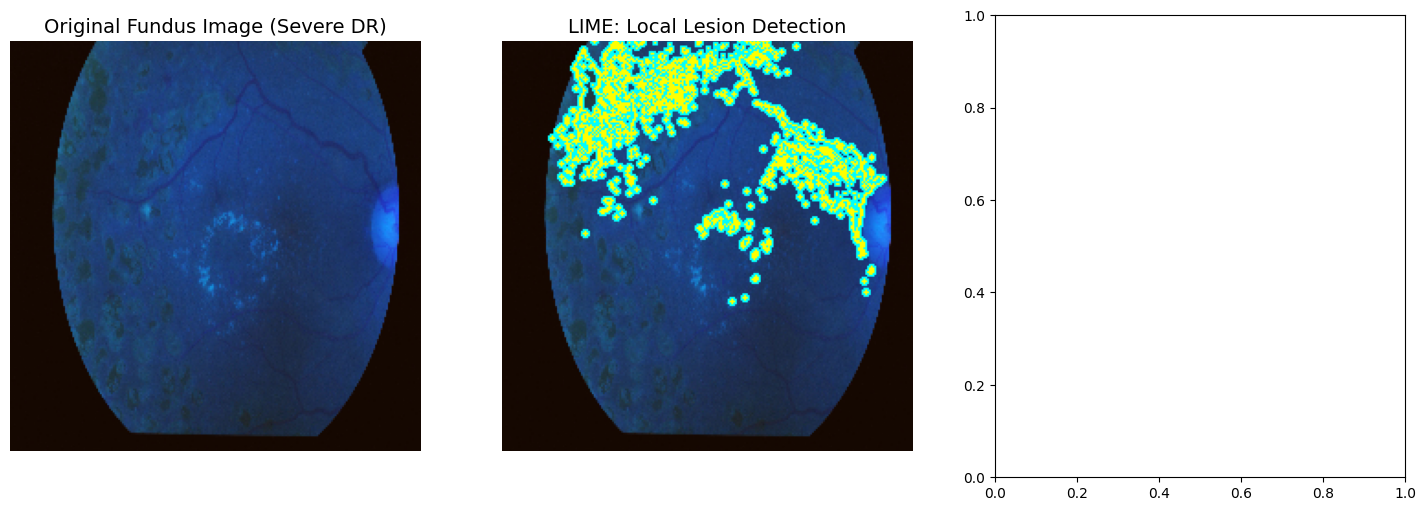

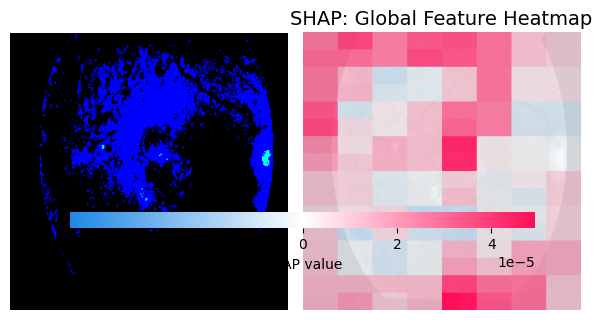

Result Saved! You can download 'Final_Research_Paper_Result.png' from the files tab.


In [ ]:
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 1. GET A CLEAR "SEVERE DR" IMAGE
# We specifically hunt for a 'Severity 4' image because they have the most obvious visible symptoms
# This looks through the validation data until it finds a Class 4 case
print("Searching for a generic Severe DR case to explain...")
target_class = '4' # Proliferative DR
found_img = False

for i in range(len(valid_generator)):
    batch_x, batch_y = valid_generator[i]
    # batch_y is one-hot encoded (e.g., [0, 0, 0, 0, 1])
    # We check which images in this batch are class 4
    indices = np.where(np.argmax(batch_y, axis=1) == 4)[0]

    if len(indices) > 0:
        # Found one!
        sample_image = batch_x[indices[0]]
        print("Found a Severe DR case! Analyzing now...")
        found_img = True
        break

if not found_img:
    print("Could not find a Class 4 image in this batch. Using the first available image instead.")
    sample_image = valid_generator[0][0][0]

# 2. RUN HIGH-RES LIME
print("Generating LIME (Superpixel) Explanation...")
explainer_lime = lime_image.LimeImageExplainer()
explanation = explainer_lime.explain_instance(
    sample_image.astype('double'),
    model.predict,
    top_labels=5,
    hide_color=None, # Changed from 0 to None so we can see the eye behind the highlight
    num_samples=1000
)

# Get the mask (Outline only)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False # Keep the eye visible
)

# 3. RUN HIGH-RES SHAP
print("Generating SHAP (Heatmap) Explanation...")
# We use a finer masking grid to make the heatmap smoother (less blocky)
masker = shap.maskers.Image("inpaint_telea", sample_image.shape)
explainer_shap = shap.Explainer(model, masker)
# Running on just 1 image for speed, but with high max_evals for quality
shap_values = explainer_shap(np.array([sample_image]), max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

# 4. PLOT THE PROFESSIONAL COMPARISON
plt.figure(figsize=(18, 6))

# Original Eye
plt.subplot(1, 3, 1)
# We normalize the image to 0-1 range for display
disp_img = sample_image - np.min(sample_image)
disp_img = disp_img / np.max(disp_img)
plt.imshow(disp_img)
plt.title("Original Fundus Image (Severe DR)", fontsize=14)
plt.axis('off')

# LIME Result
plt.subplot(1, 3, 2)
plt.imshow(mark_boundaries(disp_img, mask, color=(1, 1, 0), outline_color=(0, 1, 1))) # Yellow/Cyan lines
plt.title("LIME: Local Lesion Detection", fontsize=14)
plt.axis('off')

# SHAP Result
plt.subplot(1, 3, 3)
shap.image_plot(shap_values, show=False)
plt.title("SHAP: Global Feature Heatmap", fontsize=14)

plt.tight_layout()
plt.savefig("Final_Research_Paper_Result.png", dpi=300) # High quality save
plt.show()

print("Result Saved! You can download 'Final_Research_Paper_Result.png' from the files tab.")